In [1]:
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import random 
import spacy
import time
import csv
import re
from joblib import Parallel, delayed

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


stopwords = set(stopwords.words("english"))

In [2]:
URL = []
content = []
flag = False

with open("nytimes_news_articles.txt", "r") as file:
    for line in file:
        if(flag):
            if line.startswith("URL: "):
                # When current article ends
                # Append all content, set the flag
                flag = False
                content.append(get_content)
                get_content = []
            else:
                # Store article content 
                if line.strip():
                    get_content.append(line)
            
        if line.startswith("URL: "):
            # We are here when we encounter a *new article*
            get_content = []
            flag = True
            URL.append(line.strip().replace("URL: ", ""))

# Since the last URL doesn't have any content, we remove it
del URL[-1]   
len(URL)

8887

In [5]:
df_full = pd.DataFrame({'url': URL, 'content': content})
df_full['content']= df_full['content'].str.join(' ')

news_category = []
headline = []
dates = []

for row in df_full['url']:
    # Get dates
    href_split = re.split(r'[0-9]+/[0-9]+/[0-9]+', row)[-1]
    date = re.search(r'[0-9]+/[0-9]+/[0-9]+', row)
    dates.append(date.group())
    # Get news category
    news_category.append("-".join(i for i in href_split.split('/')[:-1]).strip('-'))
    # Get headline
    headline.append((href_split.split('/')[-1].replace(".html", "").replace("-", " ")).title())
    
df_full['date'] = dates
df_full['news_category'] = news_category
df_full['headline'] = headline
df_full = df_full[['news_category', 'headline', 'content', 'date']]
df_full.tail()

,news_category,headline,content,date
8882,nyregion,Man Killed In Police Shooting In Queens Author...,New York City officers shot and killed a 32-ye...,2016/04/18
8883,us-politics,Battle For Senate,There is a second critical contest in America’...,2016/04/18
8884,nyregion,He Said His Car Had Been Stolen The Police Say...,"On April 1, police officers from the 108th Pre...",2016/04/18
8885,world-asia,Farmers In Arid India Share Camps With Their C...,"KHILAD, India — The cattle camp, on a dusty ba...",2016/04/18
8886,movies,Jj Abrams Hints Reys Father Is Not Who You Tho...,The director J.J. Abrams dropped a possible hi...,2016/04/18


In [6]:
df_full.to_csv('nytimes_news_articles_full.csv')

## Processing

For the content:
1. Lower case
2. Remove punctuation
3. Lemmatize
4. Remove /n, /t etc.

Then, only collect articles belonging to 4 categories: (i) sports-soccer, (ii) sports-hockey, (iii) world-middleeast and (iv) world-americas.

Then only use words with min_df=10 (appering in at least 10 documents) and max_df=05 (appearing at most in 50% of the documents)

In [9]:
def getWordNetPOS(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tagdict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tagdict.get(tag, wordnet.NOUN)

# getWordNetPOS('unceremoniously')

stop_words = stopwords
lemmatizer = WordNetLemmatizer()
def process(text):
    text = text.lower()
    text.replace("\n", "")
    text.replace("\t", "")
    punctuation = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for x in punctuation:
        text = re.sub(r'[^\w\s]', " ", text)
    newwords = []
    for word in text.split():
        if (len(word) > 2) and (word.isalpha() is True):
            newwords.append(lemmatizer.lemmatize(word, getWordNetPOS(word)))
    return " ".join(newwords)

In [10]:
def size(text):
    return len(text.split())

categories = ['sports-soccer', 'sports-hockey', 'world-middleeast', 'world-americas']
df = df_full.loc[df_full['news_category'].isin(categories)]
len(df)

642

In [11]:
df.content = df.content.apply(process)
df = df[['news_category', 'content', 'date']]
df['size'] = df.content.apply(size)
df.head()

/var/folders/ff/5brjt_h91x943bw8pn3jw1b00000gr/T/ipykernel_61148/2282026698.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.content = df.content.apply(process)


,news_category,content,date,size
16,world-middleeast,paris when the body islamic state fighter be r...,2016/06/30,1112
24,sports-soccer,clairefontaine france like theater audience de...,2016/06/30,419
26,world-americas,mexico city judge here have temporarily halt t...,2016/06/30,262
28,world-middleeast,united nation saudi arabia should oust from th...,2016/06/30,433
31,sports-hockey,the score starve devil acquire former overall ...,2016/06/30,614


In [12]:
df = df[df['size'] > 50]
print(f'Number of articles = {len(df)}')
for section in np.unique(df.news_category):
    print(f'Section name: {section}, count = {np.sum(df.news_category==section)}')

Number of articles = 641
Section name: sports-hockey, count = 119
Section name: sports-soccer, count = 182
Section name: world-americas, count = 124
Section name: world-middleeast, count = 216


In [13]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(min_df=20, max_df=0.5, max_features=500)
vect.fit(df.content)
Y = vect.transform(df.content)
Y = Y.toarray()
Y.shape # (m,V)

(641, 500)

In [14]:
Y.sum(axis=0).min() # word frequencies minimum

117

In [15]:
sizes = Y.sum(axis=1)

# one document has no words, remove it
Y = Y[sizes>10]
Y.shape

(641, 500)

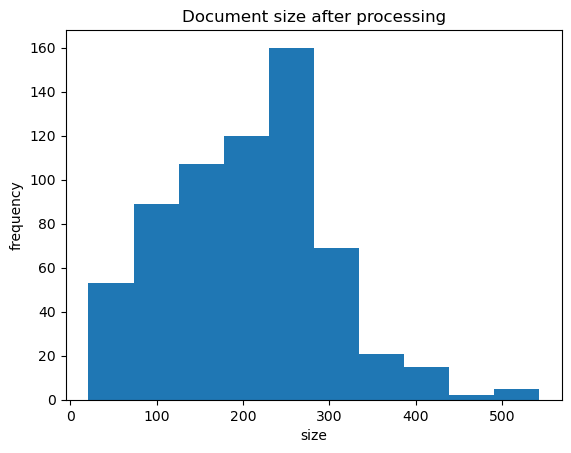

In [16]:
import matplotlib.pyplot as plt

plt.hist(Y.sum(axis=1))
plt.title('Document size after processing')
plt.xlabel('size')
plt.ylabel('frequency')
plt.show()

In [17]:
# 10 most common words after the processing

word_freq = Y.sum(axis=0)
ind = np.argpartition(word_freq, -10)[-10:]

key_list = list(vect.vocabulary_.keys())
val_list = list(vect.vocabulary_.values())
 
# print key with val 100
for i in ind:
    position = val_list.index(i)
    print(key_list[position])

score
her
play
player
united
game
city
team
goal
government


In [18]:
Y.sum()

131415

## Splitting the data and saving

We split the data into a training (70%) and a test data. We then save this data as a npy file that we use for fitting.

In [19]:
import jax.numpy as jnp
import pickle

m_train = int(0.7 * len(Y))
Y_train = Y[:m_train]
Y_test = Y[m_train:]
section_train = df.news_category.to_numpy()[:m_train]
section_test = df.news_category.to_numpy()[m_train:]

m = Y_train.shape[0]
V = Y_train.shape[1]
n = []
word_id = []
doc_id = []

for i in range(m):
    doc = Y_train[i]
    n_doc = 0
    for j in range(V):
        if Y[i,j] > 0:
            doc_id = doc_id + [i] * Y_train[i,j]
            word_id = word_id + [j] * Y_train[i,j]
            n_doc += Y_train[i,j]
    n.append(n_doc)
    
words = np.zeros((len(doc_id), 2))
words[:,0] = doc_id
words[:,1] = word_id
corpus = jnp.array(words, dtype=jnp.int32)

vocab = vect.vocabulary_
nyt_data = {
    'vocab': vocab,
    'Y_train': Y_train,
    'Y_test': Y_test,
    'category_train': section_train,
    'category_test': section_test,
    'corpus': corpus,
    'm': m,
    'n': n,
    'min_df': 20,
    'max_df': 0.5,
    'max_features': 500,
    'Y': Y,
    'category': df.news_category
}

with open('nyt_data.pkl', 'wb') as f:
    pickle.dump(nyt_data, f)

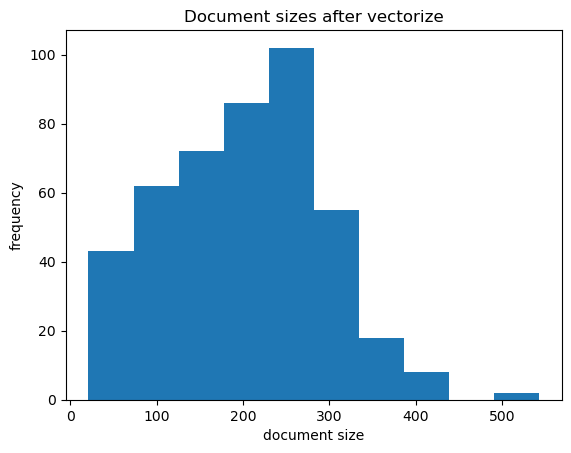

Documents: 448, vocabulary size: 500, total words = 90667


In [20]:
with open('nyt_data.pkl', 'rb') as f:
    data = pickle.load(f)
    
vocab = data['vocab']
Y_train, Y_test, category_train, category_test = data['Y_train'], data['Y_test'], data['category_train'], data['category_test']
Y, category = data['Y'], data['category']
corpus = data['corpus']
m = data['m']
n = data['n']

plt.hist(n, bins=10)
plt.title('Document sizes after vectorize')
plt.xlabel('document size')
plt.ylabel('frequency')
plt.show()

V = Y.shape[1]
print(f'Documents: {m}, vocabulary size: {V}, total words = {len(corpus)}')

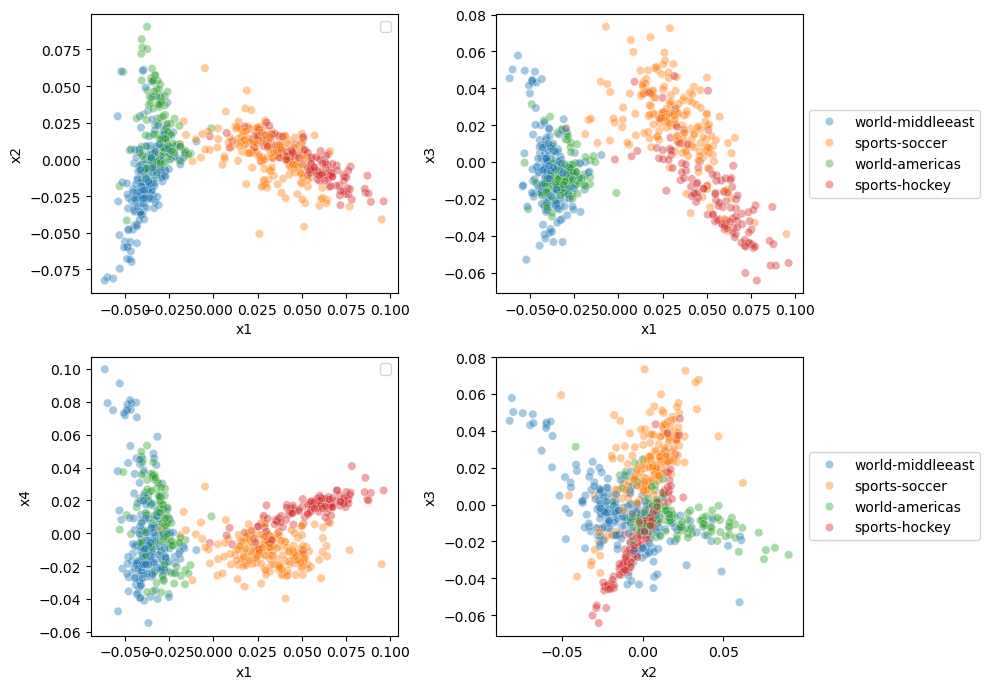

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

Y_prop = Y / Y.sum(axis=1)[:,None]
Y_pca = PCA(n_components=4).fit_transform(Y_prop)

PCA_df = pd.DataFrame({'x1': Y_pca[:,0], 
                       'x2': Y_pca[:,1], 
                       'x3': Y_pca[:,2],
                       'x4': Y_pca[:,3],
                       'section': df.news_category})

fig = plt.figure(figsize=(10, 7))

plt.subplot(2,2,1)
sns.scatterplot(data=PCA_df, x='x1', y='x2', hue='section', alpha=0.4)
plt.legend([])

plt.subplot(2,2,2)
sns.scatterplot(data=PCA_df, x='x1', y='x3', hue='section', alpha=0.4)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(2,2,3)
sns.scatterplot(data=PCA_df, x='x1', y='x4', hue='section', alpha=0.4)
plt.legend([])

plt.subplot(2,2,4)
sns.scatterplot(data=PCA_df, x='x2', y='x3', hue='section', alpha=0.4)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()